<a href="https://colab.research.google.com/github/TRach07/Variational-Autoencoder-VAE-/blob/main/Variational_Autoencoder_(VAE)_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Autoencoder (VAE) Implementation**

**1. Import Libraries and Load Dataset**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Preprocess data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


**2. Define VAE Components**

In [2]:
# Encoder
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(256, activation="relu")
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)

    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# Reparameterization trick
def sample_z(mean, log_var):
    epsilon = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log_var) * epsilon

# Decoder
class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(256, activation="relu")
        self.dense2 = layers.Dense(28 * 28, activation="sigmoid")
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, z):
        z = self.dense1(z)
        z = self.dense2(z)
        return self.reshape(z)

# VAE Model
class VAE(Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        mean, log_var = self.encoder(x)
        z = sample_z(mean, log_var)
        reconstruction = self.decoder(z)
        return reconstruction, mean, log_var

**3. Define Loss Function and Optimizer**

In [3]:
# VAE Loss Function
def vae_loss(x, reconstruction, mean, log_var):
    # Reconstruction loss (binary cross entropy)
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(
            tf.reshape(x, [-1, 28*28]),
            tf.reshape(reconstruction, [-1, 28*28])
        )
    )
    reconstruction_loss *= 28 * 28

    # KL divergence loss
    kl_divergence = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
    )

    return reconstruction_loss + kl_divergence

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

**4. Training Setup**

In [4]:
# Model parameters
latent_dim = 2

# Initialize models
encoder = Encoder(latent_dim)
decoder = Decoder()
vae = VAE(encoder, decoder)

# Training step
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        reconstruction, mean, log_var = vae(x)
        loss = vae_loss(x, reconstruction, mean, log_var)

    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# Prepare dataset
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(60000).batch(batch_size)

**5. Training Loop**

In [5]:
# Training parameters
epochs = 20
train_losses = []

print("Starting VAE training...")
for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0

    for x_batch in train_dataset:
        loss = train_step(x_batch)
        epoch_loss += loss.numpy()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

print("Training completed!")

Starting VAE training...
Epoch 1/20, Loss: 206.7614
Epoch 2/20, Loss: 174.0953
Epoch 3/20, Loss: 168.1263
Epoch 4/20, Loss: 165.4652
Epoch 5/20, Loss: 163.6686
Epoch 6/20, Loss: 162.2368
Epoch 7/20, Loss: 160.9510
Epoch 8/20, Loss: 159.7923
Epoch 9/20, Loss: 158.7092
Epoch 10/20, Loss: 157.7953
Epoch 11/20, Loss: 156.9233
Epoch 12/20, Loss: 156.1980
Epoch 13/20, Loss: 155.5309
Epoch 14/20, Loss: 154.9500
Epoch 15/20, Loss: 154.4376
Epoch 16/20, Loss: 153.9570
Epoch 17/20, Loss: 153.4932
Epoch 18/20, Loss: 153.1291
Epoch 19/20, Loss: 152.7727
Epoch 20/20, Loss: 152.4317
Training completed!


**6. Visualization Functions**

In [6]:
def plot_training_loss(losses):
    """Plot training loss over epochs"""
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('VAE Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def plot_reconstructions(model, test_data, num_samples=10):
    """Plot original and reconstructed images"""
    # Get test samples
    sample_indices = np.random.choice(len(test_data), num_samples)
    samples = test_data[sample_indices]

    # Get reconstructions
    reconstructions, _, _ = model(samples)

    # Plot
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))

    for i in range(num_samples):
        # Original images
        axes[0, i].imshow(samples[i].squeeze(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Reconstructed images
        axes[1, i].imshow(reconstructions[i].numpy().squeeze(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_latent_space(model, test_data, test_labels=None):
    """Plot 2D latent space (only works with latent_dim=2)"""
    if latent_dim != 2:
        print("Latent space visualization only works with 2D latent space")
        return

    # Encode test data
    mean, _ = model.encoder(test_data[:1000])
    z_points = mean.numpy()

    plt.figure(figsize=(12, 10))

    if test_labels is not None:
        scatter = plt.scatter(z_points[:, 0], z_points[:, 1],
                            c=test_labels[:1000], cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, label='Digit Class')
    else:
        plt.scatter(z_points[:, 0], z_points[:, 1], alpha=0.7)

    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.title('2D Latent Space Visualization')
    plt.grid(True, alpha=0.3)
    plt.show()

**7. Results and Analysis**

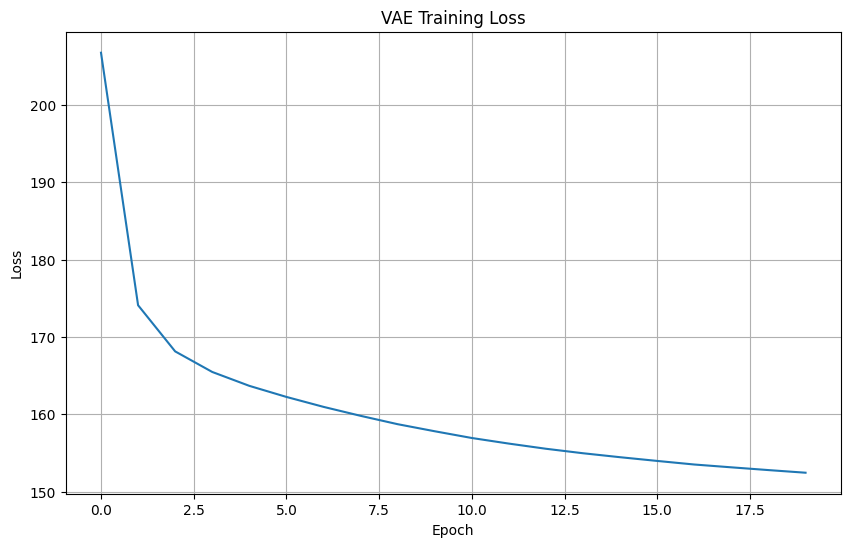

Visualizing reconstructions...


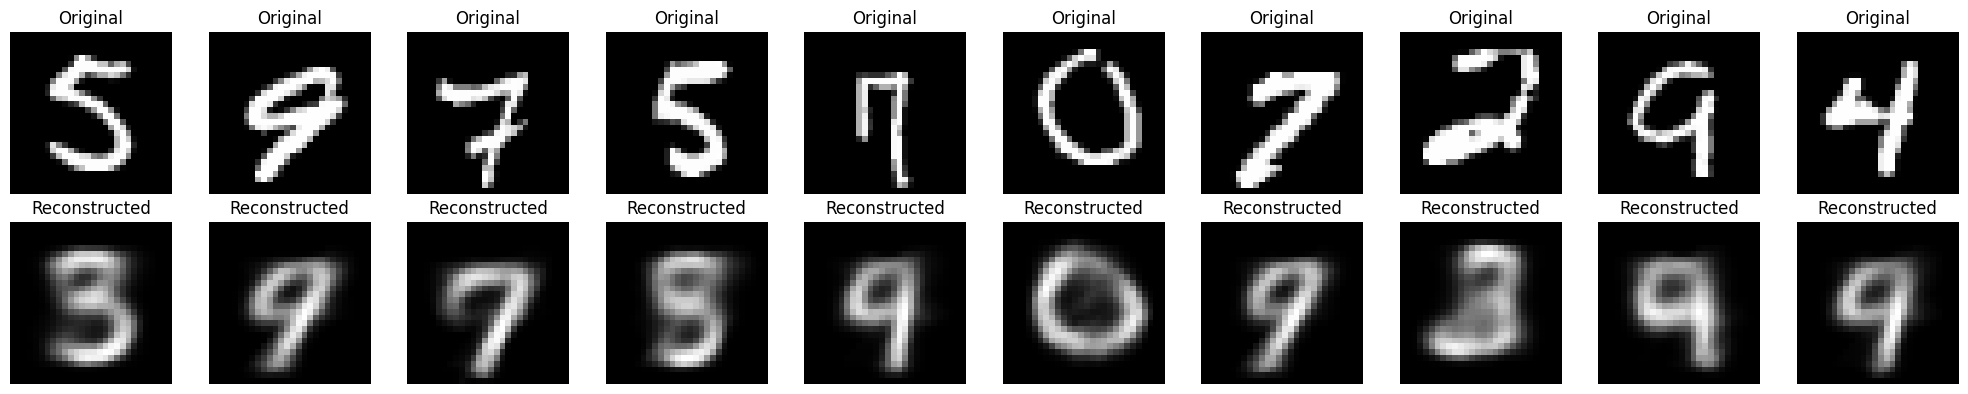

Visualizing latent space...


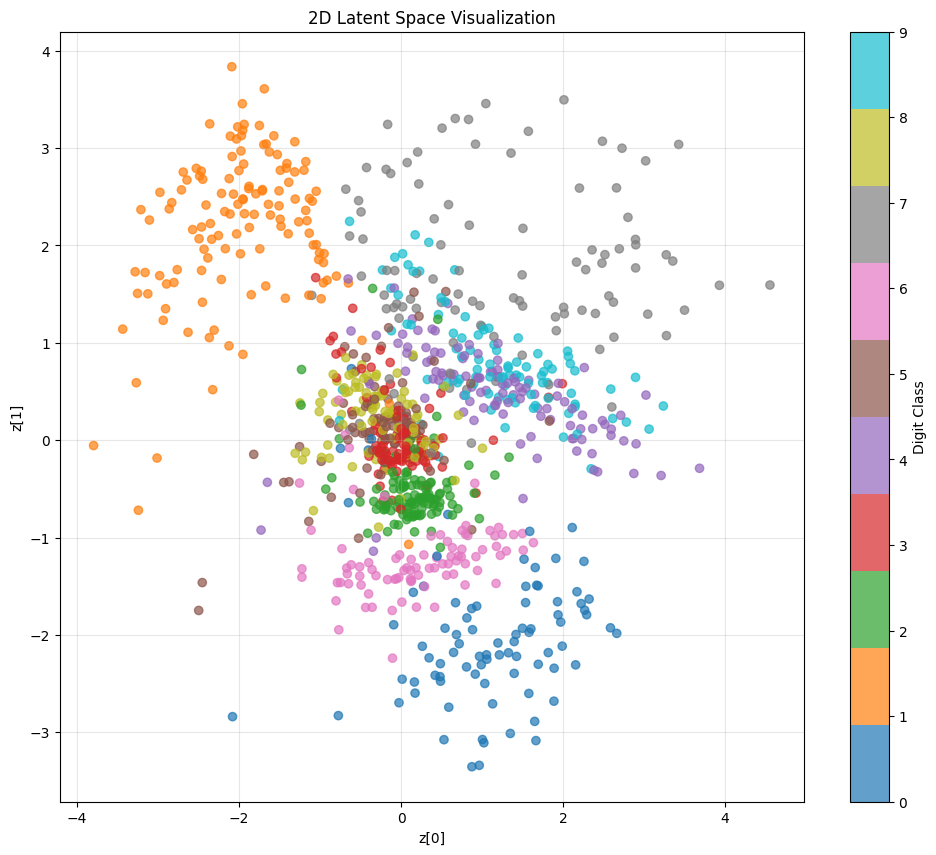

In [7]:
# Plot training loss
plot_training_loss(train_losses)

# Visualize reconstructions
print("Visualizing reconstructions...")
plot_reconstructions(vae, x_test)

# Visualize latent space (if latent_dim=2)
if latent_dim == 2:
    print("Visualizing latent space...")
    # We need labels for coloring
    (_, y_train), (_, y_test) = tf.keras.datasets.mnist.load_data()
    plot_latent_space(vae, x_test, y_test)

8. Enhanced VAE Architecture

In [8]:
# Enhanced VAE Components with Convolutional Layers
class EnhancedEncoder(Model):
    def __init__(self, latent_dim):
        super(EnhancedEncoder, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")
        self.conv2 = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(256, activation="relu")
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

class EnhancedDecoder(Model):
    def __init__(self):
        super(EnhancedDecoder, self).__init__()
        self.dense = layers.Dense(7*7*64, activation="relu")
        self.reshape = layers.Reshape((7, 7, 64))
        self.conv1 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")
        self.conv2 = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")
        self.conv3 = layers.Conv2D(1, 3, activation="sigmoid", padding="same")

    def call(self, z):
        x = self.dense(z)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

# Fixed loss function with compatible MSE
def improved_vae_loss(x, reconstruction, mean, log_var, beta=0.1):
    # Reconstruction loss using compatible MSE
    reconstruction_loss = tf.reduce_mean(
        tf.square(tf.reshape(x, [-1, 28*28]) - tf.reshape(reconstruction, [-1, 28*28]))
    )
    reconstruction_loss *= 28 * 28

    # KL divergence with beta parameter for better balance
    kl_divergence = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
    )

    return reconstruction_loss + beta * kl_divergence

**9. Enhanced Training Setup**

In [9]:
# Enhanced training setup
enhanced_latent_dim = 16  # Increased latent dimension for better reconstructions
enhanced_encoder = EnhancedEncoder(enhanced_latent_dim)
enhanced_decoder = EnhancedDecoder()
enhanced_vae = VAE(enhanced_encoder, enhanced_decoder)

# Improved optimizer with lower learning rate
enhanced_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def enhanced_train_step(x):
    with tf.GradientTape() as tape:
        reconstruction, mean, log_var = enhanced_vae(x)
        loss = improved_vae_loss(x, reconstruction, mean, log_var, beta=0.1)

    gradients = tape.gradient(loss, enhanced_vae.trainable_variables)
    enhanced_optimizer.apply_gradients(zip(gradients, enhanced_vae.trainable_variables))
    return loss

**10. Enhanced Training Loop**

In [10]:
# Enhanced training parameters
enhanced_epochs = 30
enhanced_train_losses = []

print("Starting Enhanced VAE training...")
for epoch in range(enhanced_epochs):
    epoch_loss = 0
    num_batches = 0

    for x_batch in train_dataset:
        loss = enhanced_train_step(x_batch)
        epoch_loss += loss.numpy()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    enhanced_train_losses.append(avg_loss)
    print(f"Enhanced Epoch {epoch + 1}/{enhanced_epochs}, Loss: {avg_loss:.4f}")

print("Enhanced training completed!")

Starting Enhanced VAE training...
Enhanced Epoch 1/30, Loss: 75.0448
Enhanced Epoch 2/30, Loss: 43.0771
Enhanced Epoch 3/30, Loss: 24.2393
Enhanced Epoch 4/30, Loss: 18.3676
Enhanced Epoch 5/30, Loss: 16.1255
Enhanced Epoch 6/30, Loss: 15.0208
Enhanced Epoch 7/30, Loss: 14.3316
Enhanced Epoch 8/30, Loss: 13.8387
Enhanced Epoch 9/30, Loss: 13.4560
Enhanced Epoch 10/30, Loss: 13.1427
Enhanced Epoch 11/30, Loss: 12.8628
Enhanced Epoch 12/30, Loss: 12.6451
Enhanced Epoch 13/30, Loss: 12.4442
Enhanced Epoch 14/30, Loss: 12.2725
Enhanced Epoch 15/30, Loss: 12.1217
Enhanced Epoch 16/30, Loss: 11.9728
Enhanced Epoch 17/30, Loss: 11.8525
Enhanced Epoch 18/30, Loss: 11.7265
Enhanced Epoch 19/30, Loss: 11.6232
Enhanced Epoch 20/30, Loss: 11.5208
Enhanced Epoch 21/30, Loss: 11.4307
Enhanced Epoch 22/30, Loss: 11.3385
Enhanced Epoch 23/30, Loss: 11.2639
Enhanced Epoch 24/30, Loss: 11.1881
Enhanced Epoch 25/30, Loss: 11.1117
Enhanced Epoch 26/30, Loss: 11.0452
Enhanced Epoch 27/30, Loss: 10.9915
Enh

**11. Comparison and Evaluation**

Comparing model performances...


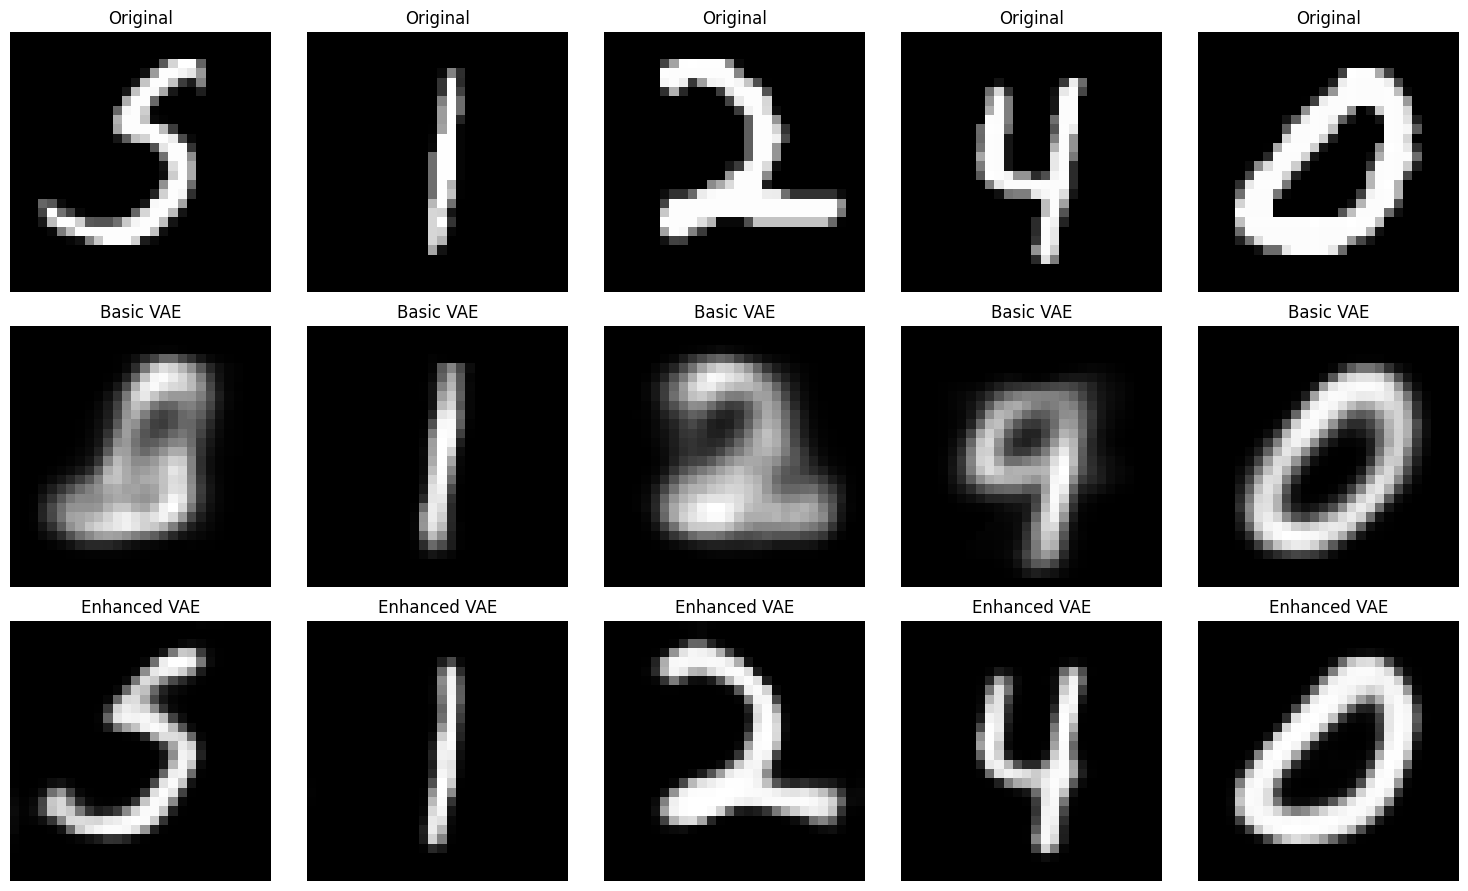

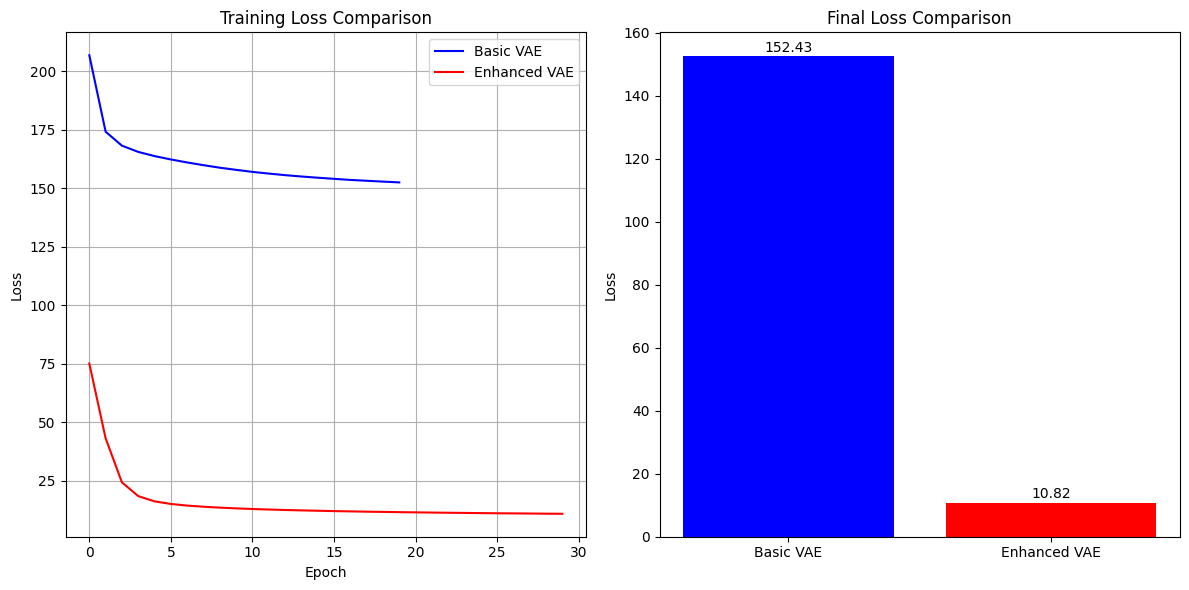

In [11]:
def compare_reconstructions(basic_model, enhanced_model, test_data, num_samples=5):
    """Compare reconstructions from both models"""
    sample_indices = np.random.choice(len(test_data), num_samples)
    samples = test_data[sample_indices]

    # Get reconstructions from both models
    basic_reconstructions, _, _ = basic_model(samples)
    enhanced_reconstructions, _, _ = enhanced_model(samples)

    # Plot comparison
    fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 3, 9))

    for i in range(num_samples):
        # Original images
        axes[0, i].imshow(samples[i].squeeze(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Basic VAE reconstructions
        axes[1, i].imshow(basic_reconstructions[i].numpy().squeeze(), cmap='gray')
        axes[1, i].set_title('Basic VAE')
        axes[1, i].axis('off')

        # Enhanced VAE reconstructions
        axes[2, i].imshow(enhanced_reconstructions[i].numpy().squeeze(), cmap='gray')
        axes[2, i].set_title('Enhanced VAE')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_comparison_loss(basic_losses, enhanced_losses):
    """Compare training losses of both models"""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(basic_losses, label='Basic VAE', color='blue')
    plt.plot(enhanced_losses, label='Enhanced VAE', color='red')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # Plot final losses comparison
    models = ['Basic VAE', 'Enhanced VAE']
    final_losses = [basic_losses[-1], enhanced_losses[-1]]
    bars = plt.bar(models, final_losses, color=['blue', 'red'])
    plt.title('Final Loss Comparison')
    plt.ylabel('Loss')

    # Add value labels on bars
    for bar, loss in zip(bars, final_losses):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{loss:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Run comparisons
print("Comparing model performances...")
compare_reconstructions(vae, enhanced_vae, x_test)
plot_comparison_loss(train_losses, enhanced_train_losses)

**12. Advanced Visualization: Latent Space Interpolation**

Generating latent space interpolations...


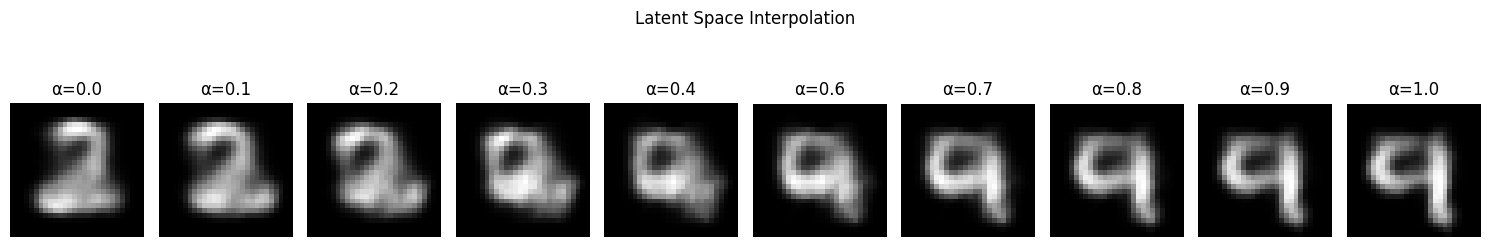

In [12]:
def interpolate_latent_space(model, test_data, num_points=10):
    """Interpolate between two points in latent space"""
    # Encode two random test samples
    idx1, idx2 = np.random.choice(len(test_data), 2, replace=False)
    sample1, sample2 = test_data[idx1:idx1+1], test_data[idx2:idx2+1]

    mean1, _ = model.encoder(sample1)
    mean2, _ = model.encoder(sample2)

    # Create interpolation points
    alphas = np.linspace(0, 1, num_points)
    interpolated_points = []

    for alpha in alphas:
        interpolated_z = alpha * mean1 + (1 - alpha) * mean2
        interpolated_points.append(interpolated_z)

    # Decode interpolated points
    interpolated_images = []
    for point in interpolated_points:
        reconstructed = model.decoder(point)
        interpolated_images.append(reconstructed.numpy().squeeze())

    # Plot interpolation
    plt.figure(figsize=(15, 3))
    for i, (alpha, img) in enumerate(zip(alphas, interpolated_images)):
        plt.subplot(1, num_points, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'α={alpha:.1f}')
        plt.axis('off')

    plt.suptitle('Latent Space Interpolation')
    plt.tight_layout()
    plt.show()

# Generate interpolations
print("Generating latent space interpolations...")
interpolate_latent_space(vae, x_test)

**13. Quantitative Evaluation**

In [13]:
def calculate_metrics(model, test_data):
    """Calculate quantitative metrics for model evaluation"""
    test_samples = test_data[:1000]  # Use subset for speed

    reconstructions, means, log_vars = model(test_samples)

    # Calculate MSE using compatible method
    mse = tf.reduce_mean(
        tf.square(tf.reshape(test_samples, [-1, 28*28]) - tf.reshape(reconstructions, [-1, 28*28])),
        axis=1
    )
    avg_mse = tf.reduce_mean(mse).numpy()

    print(f"Mean Squared Error: {avg_mse:.4f}")

    return avg_mse

print("Basic VAE Metrics:")
basic_mse = calculate_metrics(vae, x_test)

print("\nEnhanced VAE Metrics:")
enhanced_mse = calculate_metrics(enhanced_vae, x_test)

Basic VAE Metrics:
Mean Squared Error: 0.0425

Enhanced VAE Metrics:
Mean Squared Error: 0.0092


**14. Answer Questions**

1. Why use the reparameterization trick in VAEs?

   The reparameterization trick allows us to backpropagate gradients through
   the stochastic sampling process. By separating the random noise (epsilon)
   from the learnable parameters (mean and variance), we can compute gradients
   with respect to the encoder's parameters while maintaining the stochastic
   nature of the latent space.

2. How does KL divergence loss affect the latent space?

   The KL divergence loss acts as a regularizer that encourages the latent
   distribution to approximate a standard normal distribution. This ensures:
   - The latent space is continuous and structured
   - Similar data points are clustered together
   - The space can be sampled meaningfully for generation

3. Impact of latent dimension on reconstruction quality:

   - Small latent_dim (e.g., 2): Better regularization but limited
     reconstruction detail
   - Large latent_dim: Better reconstruction but risk of overfitting and
     less structured latent space
   - Optimal dimension balances reconstruction fidelity and latent space
     regularity